# 1. Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
import statsmodels.api as sm
from category_encoders import OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import plotly.graph_objs as go
from plotly.offline import iplot

# 2. Data Loading & Splitting

In [2]:
# Load dataset
df = pd.read_csv('car_evaluation.csv')
df.head()

,very high,very high.1,2,2.1,small,low,unaccepted
0,very high,very high,2,2,small,medium,unaccepted
1,very high,very high,2,2,small,high,unaccepted
2,very high,very high,2,2,medium,low,unaccepted
3,very high,very high,2,2,medium,medium,unaccepted
4,very high,very high,2,2,medium,high,unaccepted


In [3]:
# Shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,very high,very high.1,2,2.1,small,low,unaccepted
0,high,low,2,more,medium,medium,unaccepted
1,low,high,3,more,small,medium,accepted
2,low,very high,more,more,small,high,accepted
3,medium,very high,4,2,small,medium,unaccepted
4,very high,high,2,4,big,high,unaccepted


In [4]:
# dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1727 entries, 0 to 1726
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   very high    1727 non-null   object
 1   very high.1  1727 non-null   object
 2   2            1727 non-null   object
 3   2.1          1727 non-null   object
 4   small        1727 non-null   object
 5   low          1727 non-null   object
 6   unaccepted   1727 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [5]:
# Size of Dataset
R = df.shape[0]
C = df.shape[1]
print(f"Number of rows: {R}")
print(f"Number of columns: {C}")

Number of rows: 1727
Number of columns: 7


In [6]:
# Get testing data
df_test = df.iloc[:R//5, :]
df_test.head()

,very high,very high.1,2,2.1,small,low,unaccepted
0,high,low,2,more,medium,medium,unaccepted
1,low,high,3,more,small,medium,accepted
2,low,very high,more,more,small,high,accepted
3,medium,very high,4,2,small,medium,unaccepted
4,very high,high,2,4,big,high,unaccepted


In [7]:
# Display the shape
print(f"Number of rows: {df_test.shape[0]}")
print(f"Number of columns: {df_test.shape[1]}")

Number of rows: 345
Number of columns: 7


In [8]:
# Get training data
df_train = df.iloc[R//5:, :]
df_train.head()

,very high,very high.1,2,2.1,small,low,unaccepted
345,high,very high,more,2,small,low,unaccepted
346,low,medium,3,4,small,medium,accepted
347,high,high,4,more,small,medium,unaccepted
348,low,low,2,4,medium,low,unaccepted
349,low,medium,2,4,small,medium,accepted


In [9]:
# Display the shape
print(f"Number of rows: {df_train.shape[0]}")
print(f"Number of columns: {df_train.shape[1]}")

Number of rows: 1382
Number of columns: 7


# 3. EDA & Data Preprocessing

### 3.1 Training Data

In [10]:
# Size of Dataset
print(f"Number of rows: {df_train.shape[0]}")
print(f"Number of columns: {df_train.shape[1]}")

Number of rows: 1382
Number of columns: 7


In [12]:
# # Drop unnecessary columns
# df_train = df_train.drop(['Sample code number'], axis=1)
# df_train = df_train.reset_index(drop=True)
# df_train.columns

In [11]:
# Remove duplicated columns
# This will retain the first occurrences, change as you want
dup_cols = df_train.columns.duplicated()
cols = list(df_train.columns)
print(f"Duplicated Columns: \n{[cols[i] for i in range(len(cols)) if dup_cols[i]]}")

df_train = df_train.loc[:,~df_train.columns.duplicated()].copy()

print("After removing...")

dup_cols = df_train.columns.duplicated()
cols = list(df_train.columns)
print(f"Duplicated Columns: \n{[cols[i] for i in range(len(cols)) if dup_cols[i]]}")

Duplicated Columns: 
[]
After removing...
Duplicated Columns: 
[]


In [12]:
# Check for missing values
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382 entries, 345 to 1726
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   very high    1382 non-null   object
 1   very high.1  1382 non-null   object
 2   2            1382 non-null   object
 3   2.1          1382 non-null   object
 4   small        1382 non-null   object
 5   low          1382 non-null   object
 6   unaccepted   1382 non-null   object
dtypes: object(7)
memory usage: 75.7+ KB


In [13]:
# Remove row with missing values
df_train = df_train.dropna()
df_train = df_train.reset_index(drop=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382 entries, 0 to 1381
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   very high    1382 non-null   object
 1   very high.1  1382 non-null   object
 2   2            1382 non-null   object
 3   2.1          1382 non-null   object
 4   small        1382 non-null   object
 5   low          1382 non-null   object
 6   unaccepted   1382 non-null   object
dtypes: object(7)
memory usage: 75.7+ KB


In [14]:
# Drop duplicated rows
print("Number of duplicated rows:", df_train.shape[0] - df_train.drop_duplicates().shape[0])
df_train = df_train.drop_duplicates()
df_train = df_train.reset_index(drop=True)
print()
print("Removing duplicates...")
print()
print("Number of duplicated rows:", df_train.shape[0] - df_train.drop_duplicates().shape[0])

Number of duplicated rows: 0

Removing duplicates...

Number of duplicated rows: 0


In [15]:
# Rename columns
headers = ["buying price", "maintenance cost", "number of doors",
           "number of persons", "luggage boot", "safety", "decision"]
df_train.columns = headers
df_train.columns

Index(['buying price', 'maintenance cost', 'number of doors',
       'number of persons', 'luggage boot', 'safety', 'decision'],
      dtype='object')

In [16]:
# Show unique values on each X's columns
X = df_train.drop(['decision'], axis=1)

for col in X.columns:
    print(X[col].value_counts())

buying price
very high    351
medium       348
high         343
low          340
Name: count, dtype: int64
maintenance cost
low          350
very high    348
high         346
medium       338
Name: count, dtype: int64
number of doors
2       354
4       347
3       341
more    340
Name: count, dtype: int64
number of persons
2       467
4       460
more    455
Name: count, dtype: int64
luggage boot
small     467
big       458
medium    457
Name: count, dtype: int64
safety
medium    464
high      464
low       454
Name: count, dtype: int64


In [19]:
# # Drop poor features (to avoid overfitting)
# df_train = df_train.drop(['VendorID'], axis=1)
# df_train = df_train.reset_index(drop=True)
# df_train = df_train.drop(['payment_type'], axis=1)
# df_train = df_train.reset_index(drop=True)
# df_train.columns

In [20]:
# # Remove X's invalid row
# df_train = df_train[df_train["Bare Nuclei"] != "?"]

# X = df_train.drop(['Class'], axis=1)

# for col in X.columns:
#     print(X[col].value_counts())

In [17]:
# Check invalid datatypes
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382 entries, 0 to 1381
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   buying price       1382 non-null   object
 1   maintenance cost   1382 non-null   object
 2   number of doors    1382 non-null   object
 3   number of persons  1382 non-null   object
 4   luggage boot       1382 non-null   object
 5   safety             1382 non-null   object
 6   decision           1382 non-null   object
dtypes: object(7)
memory usage: 75.7+ KB


In [22]:
# # Change the data type of X's invalid columns
# df_train["Bare Nuclei"] = df_train["Bare Nuclei"].astype("int64")
# df_train.info()

In [18]:
# Show unique values on y's column
y = df_train['decision']

print(y.value_counts())

decision
unaccepted    974
accepted      304
good           55
very good      49
Name: count, dtype: int64


In [24]:
# # Remove y's invalid row
# df_train = df_train[df_train["Bare Nuclei"] != "?"]

# y = df_train['Class']

# for col in X.columns:
#     print(X[col].value_counts())

In [25]:
# # Change the data type of y's invalid column
# df_train["Bare Nuclei"] = df_train["Bare Nuclei"].astype("int64")
# df_train.info()

In [19]:
# Show categorical columns
categorical_cols = list(set(df_train.columns.to_list()) - set(df_train._get_numeric_data().columns.to_list()))

print("Categorical columns:")
print(sorted(categorical_cols))

Categorical columns:
['buying price', 'decision', 'luggage boot', 'maintenance cost', 'number of doors', 'number of persons', 'safety']


In [20]:
# Show unique values in categorical columns
unique_values = []

for col in categorical_cols:
    unique_value = [col]
    unique_value.append(", ".join(df_train[col].unique()))
    unique_values.append(unique_value)

pd.DataFrame(unique_values, columns=["col", "unique values"])

,col,unique values
0,luggage boot,"small, medium, big"
1,safety,"low, medium, high"
2,decision,"unaccepted, accepted, good, very good"
3,maintenance cost,"very high, medium, high, low"
4,buying price,"high, low, very high, medium"
5,number of doors,"more, 3, 4, 2"
6,number of persons,"2, 4, more"


In [28]:
# # Encode nominal data
# df_train = pd.get_dummies(df_train, columns=['decision'], drop_first=True)
# df_train

In [21]:
# Encode ordinal data

enc_maps = {
    "buying price" : [{'col': "buying price", 'mapping': {"low": 0, "medium": 1, "high": 2, "very high": 3}}],
    "maintenance cost" : [{'col': "maintenance cost", 'mapping': {"low": 0, "medium": 1, "high": 2, "very high": 3}}],
    "number of doors" : [{'col': "number of doors", 'mapping': {"2": 0, "3": 1, "4": 2, "more": 3}}],
    "number of persons" : [{'col': "number of persons", 'mapping': {"2": 0, "4": 1, "more": 2}}],
    "luggage boot" : [{'col': "luggage boot", 'mapping': {"small": 0, "medium": 1, "big": 2}}],
    "safety" : [{'col': "safety", 'mapping': {"low": 0, "medium": 1, "high": 2}}],
    "decision" : [{'col': "decision", 'mapping': {"unaccepted": 0, "accepted": 1, "good": 2, "very good": 3}}]
}

for col in categorical_cols:
    enc_map = enc_maps[col]

    enc = OrdinalEncoder(mapping=enc_map)
    df_train = enc.fit_transform(df_train)


df_train

,buying price,maintenance cost,number of doors,number of persons,luggage boot,safety,decision
0,2,3,3,0,0,0,0
1,0,1,1,1,0,1,1
2,2,2,2,2,0,1,0
3,0,0,0,1,1,0,0
4,0,1,0,1,0,1,1
...,...,...,...,...,...,...,...
1377,3,1,0,2,0,0,0
1378,1,2,0,2,0,0,0
1379,2,1,1,1,0,2,1
1380,1,1,1,1,0,2,1


<Axes: >

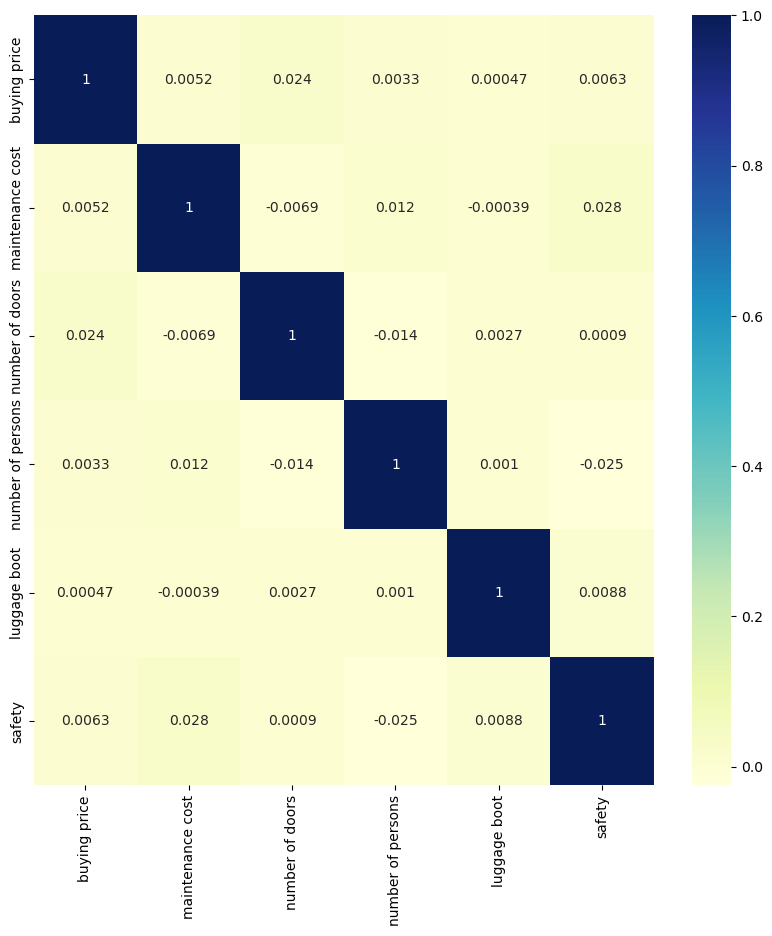

In [22]:
# Displaying heatmap
X = df_train.drop(['decision'], axis=1)

plt.subplots(figsize=(10, 10))
sns.heatmap(X.corr(method="pearson"), cmap="YlGnBu", annot=True)

In [31]:
# # Drop correlated features
# df_train = df_train.drop(['country'], axis=1)
# df_train = df_train.reset_index(drop=True)
# df_train.columns

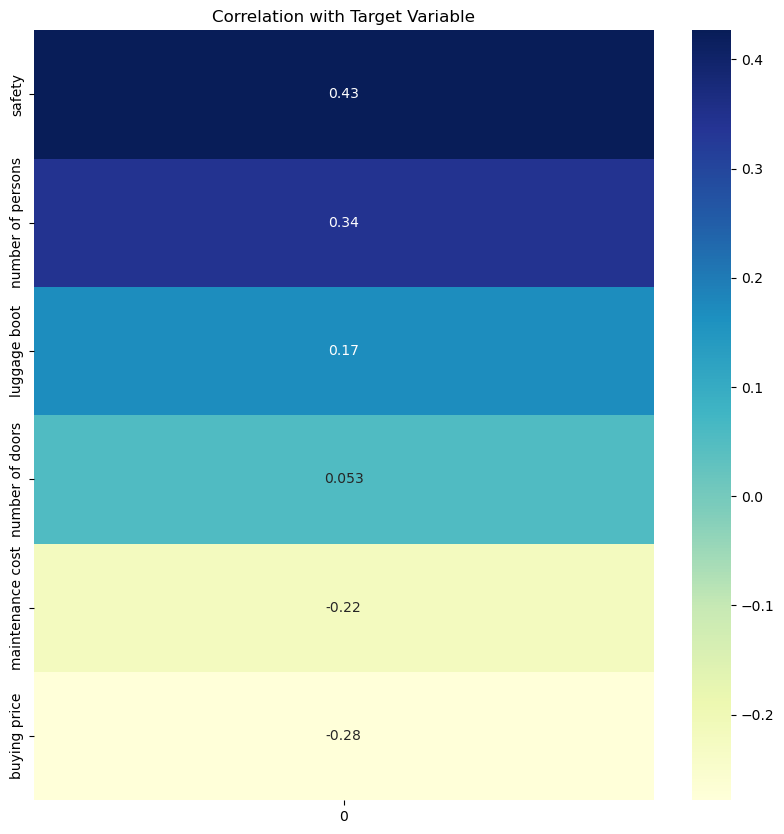

In [23]:
# Create a correlation matrix with target variable
X = df_train.drop(['decision'], axis=1)
y = df_train['decision']

corr_with_target = X.corrwith(y)
corr_with_target = corr_with_target.sort_values(ascending=False)
plt.figure(figsize=(10, 10))
sns.heatmap(corr_with_target.to_frame(), cmap='YlGnBu', annot=True)
plt.title('Correlation with Target Variable')
plt.show()

In [33]:
# # Drop unimportant features
# df_train = df_train.drop(['country'], axis=1)
# df_train = df_train.reset_index(drop=True)
# df_train.columns

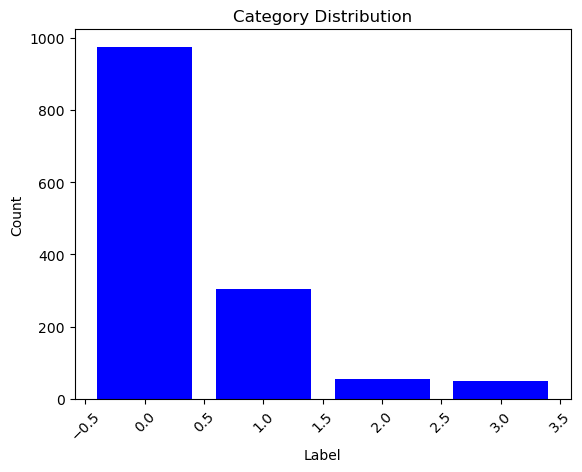

In [24]:
# Distribution of target variable
category_counts = df_train['decision'].value_counts()

# Plot the count plot
plt.bar(category_counts.index, category_counts.values, color='blue')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Category Distribution')
plt.xticks(rotation=45)  # Rotate labels for better readability if needed
plt.show()

**Important**: We detect outliers BEFORE creating polynomial features because:
1. Polynomial features amplify outliers exponentially (outlier² creates extreme values)
2. One outlier affects multiple polynomial features simultaneously  
3. This prevents model instability in polynomial regression

Do it when the data is sufficient

In [25]:
# Show all numerical columns
numerical_columns = list(df_train.select_dtypes(include=[np.number]).columns.values)
numerical_columns

['buying price',
 'maintenance cost',
 'number of doors',
 'number of persons',
 'luggage boot',
 'safety',
 'decision']

In [26]:
# Detect outliers
def detect_outliers_iqr(df, column):    
    """
    Detect outliers using IQR method
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

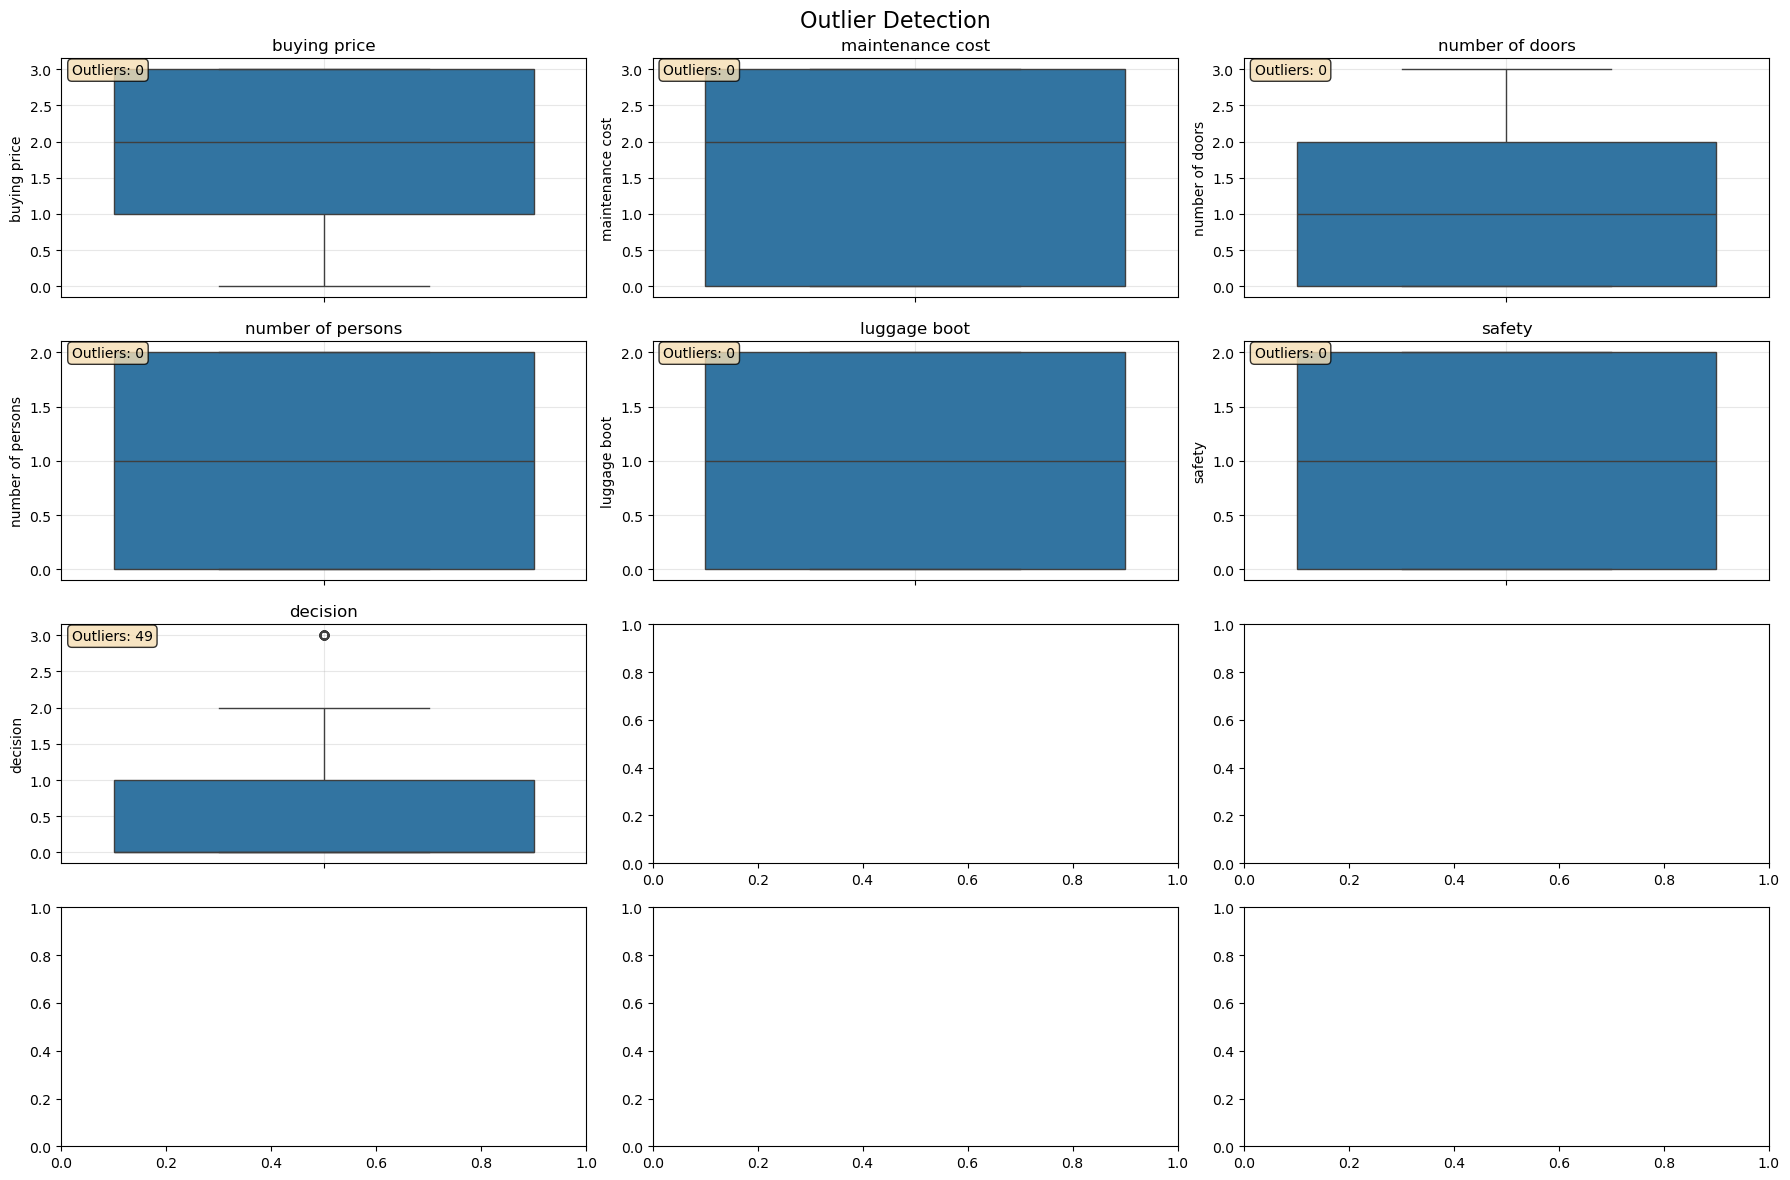

In [27]:
# Create box plots for all numerical features to visualize outliers
fig, axes = plt.subplots(4, 3, figsize=(18, 12))
fig.suptitle('Outlier Detection', fontsize=16)

lower_bounds = dict()
upper_bounds = dict()

for i, col in enumerate(numerical_columns):
    row = i // 3
    col_idx = i % 3
    
    # Create box plot
    sns.boxplot(data=df_train, y=col, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'{col}')
    axes[row, col_idx].grid(True, alpha=0.3)
    
    # Add outlier count as text
    outliers, lower_bound, upper_bound = detect_outliers_iqr(df_train, col)
    lower_bounds[col] = lower_bound
    upper_bounds[col] = upper_bound
    
    axes[row, col_idx].text(0.02, 0.98, f'Outliers: {len(outliers)}', 
                           transform=axes[row, col_idx].transAxes,
                           verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

In [28]:
# Remove same outliers

print(f"Number of rows: {df_train.shape[0]}")

print("\nRemoving outliers...\n")

outlier_condition = True
for col in numerical_columns:
    # A row is an outlier if it's OUTSIDE the bounds (< lower OR > upper)
    outlier_condition = outlier_condition & ((df_train[col] < lower_bounds[col]) | (df_train[col] > upper_bounds[col]))

# Remove rows that are outliers in ALL columns
df_train = df_train[~outlier_condition]
df_train = df_train.reset_index(drop=True)

print(f"Number of rows: {df_train.shape[0]}")

Number of rows: 1382

Removing outliers...

Number of rows: 1382


In [39]:
# # Remove individual outliers (only if the dataset is big enough)

# print(f"Number of rows: {df_train.shape[0]}")

# for i, col in enumerate(numerical_columns):
    
#     df_train = df_train[df_train[col] >= lower_bounds[col]]
#     df_train = df_train.reset_index(drop=True)
#     df_train = df_train[df_train[col] <= upper_bounds[col]]
#     df_train = df_train.reset_index(drop=True)

# print(f"Number of rows: {df_train.shape[0]}")

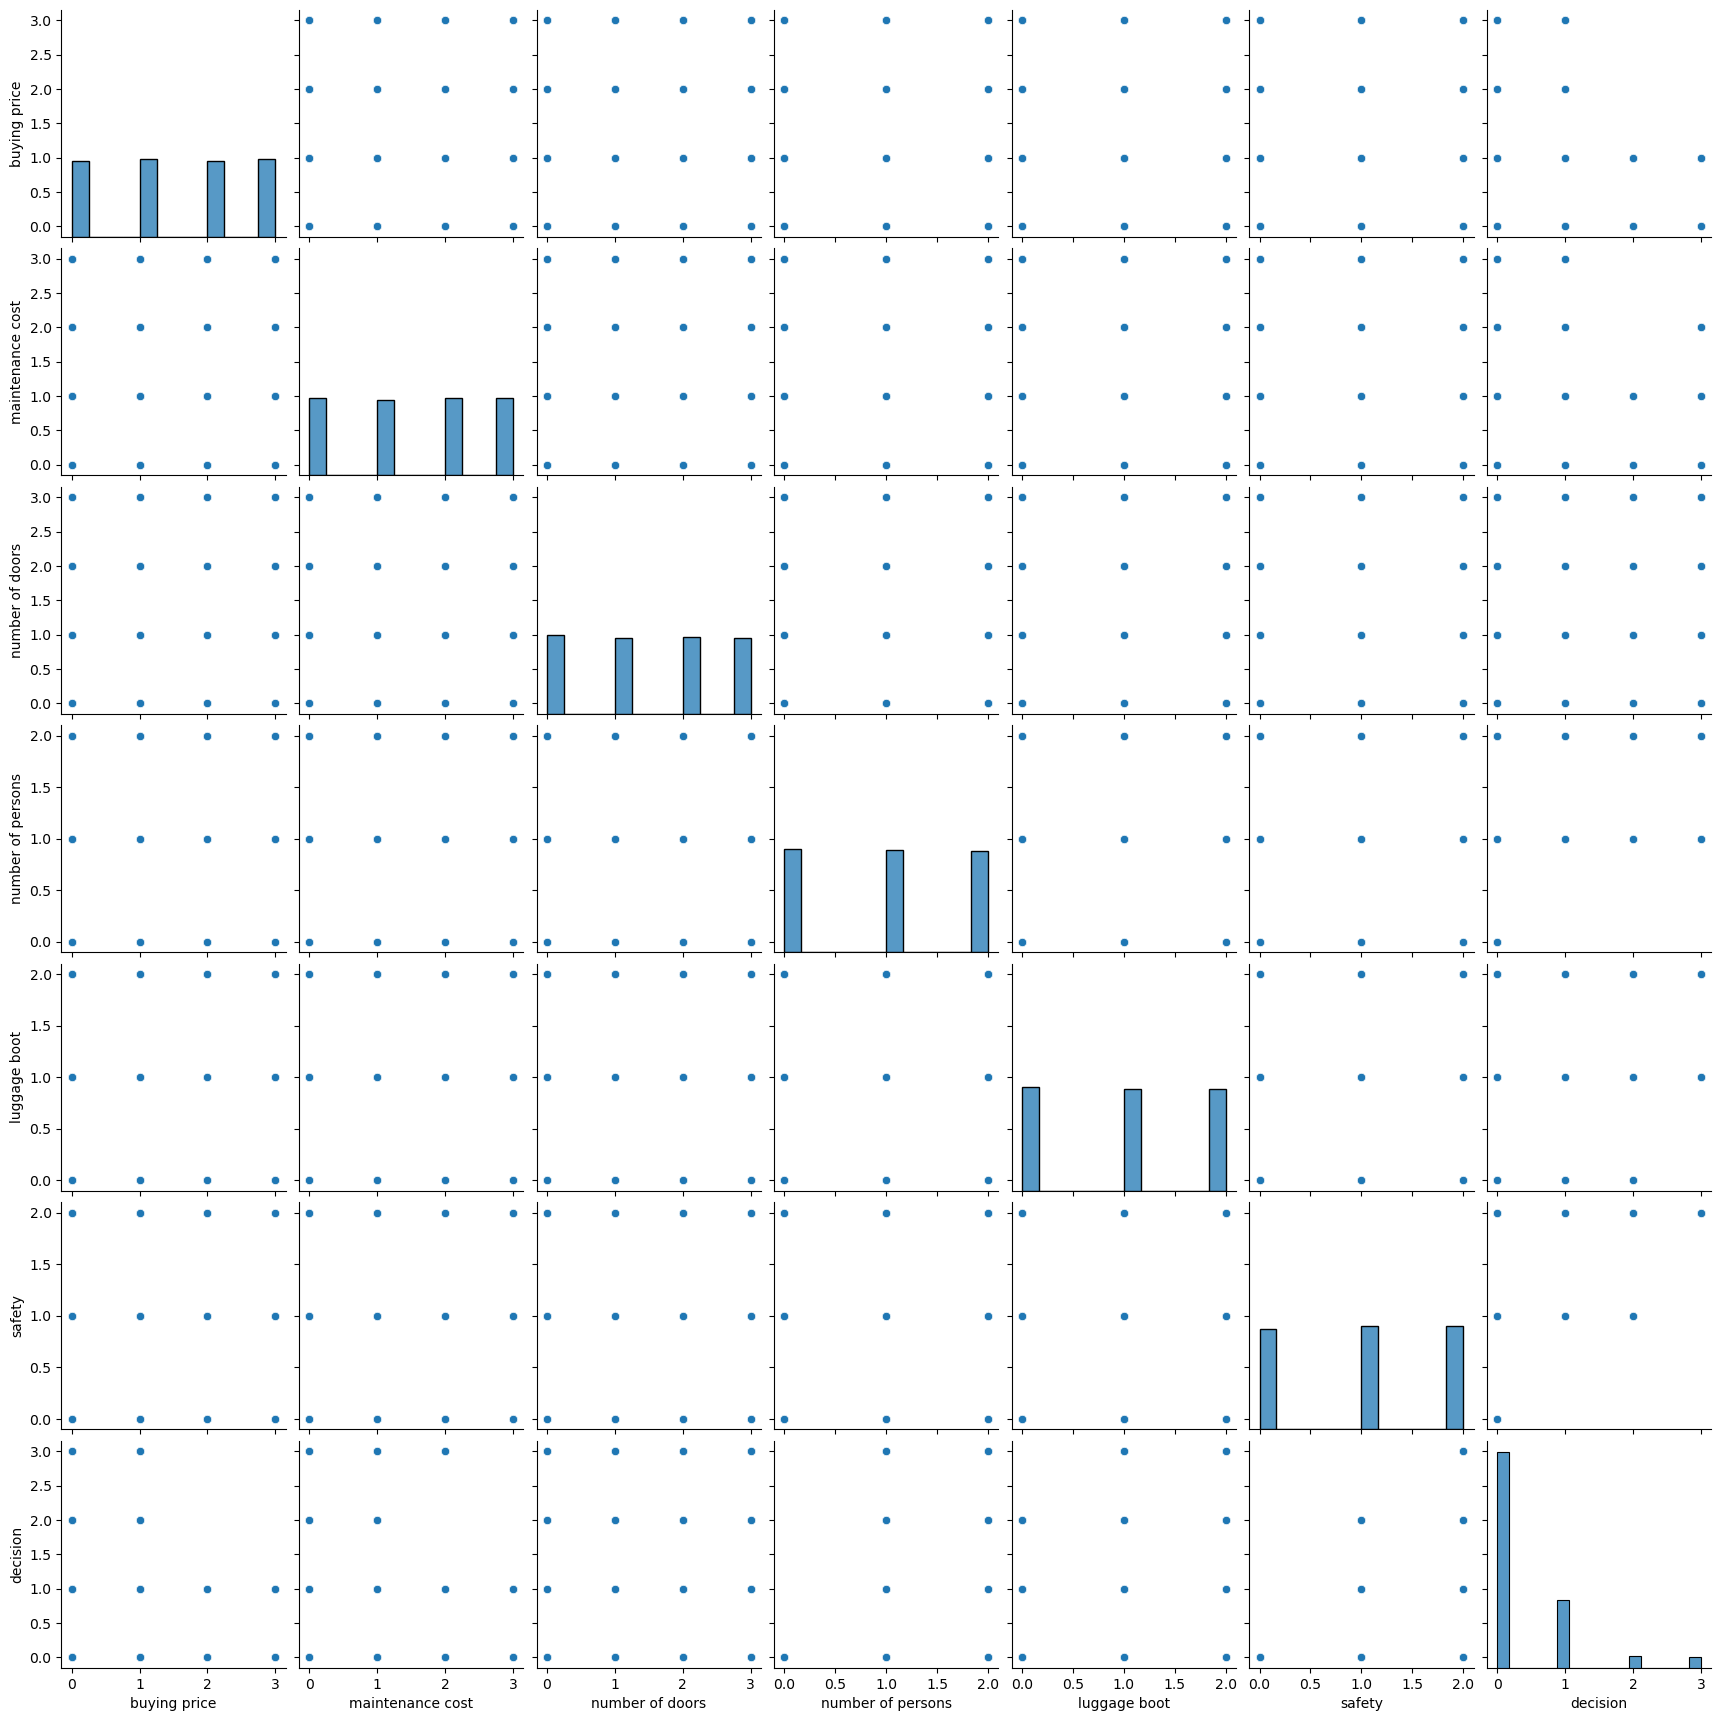

In [29]:
# Show the distribution of all columns
sns.pairplot(df_train)

In [30]:
# Show statistical information of the dataset
df_train.describe()

,buying price,maintenance cost,number of doors,number of persons,luggage boot,safety,decision
count,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000
mean,1.510130,1.500724,1.486975,0.991317,0.993488,1.007236,0.405933
std,1.118393,1.122961,1.120304,0.817041,0.818390,0.815281,0.730663
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000,1.000000
max,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,3.000000


In [31]:
# Separate features and labels
y_train = df_train['decision']
X_train = df_train.drop(['decision'], axis=1)

In [ ]:
# # MinMax Scaling
# numeric_cols = X_train.select_dtypes(include='number').columns

# scaler_X = MinMaxScaler()

# X_train[numeric_cols] = scaler_X.fit_transform(X_train[numeric_cols])

In [32]:
X_train.describe()

,buying price,maintenance cost,number of doors,number of persons,luggage boot,safety
count,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000
mean,1.510130,1.500724,1.486975,0.991317,0.993488,1.007236
std,1.118393,1.122961,1.120304,0.817041,0.818390,0.815281
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000
75%,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000
max,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000


### 3.2 Testing Data

In [33]:
# Size of Dataset
print(f"Number of rows: {df_test.shape[0]}")
print(f"Number of columns: {df_test.shape[1]}")

Number of rows: 345
Number of columns: 7


In [47]:
# # Drop unnecessary columns
# df_test = df_test.drop(['Sample code number'], axis=1)
# df_test = df_test.reset_index(drop=True)
# df_test.columns

In [34]:
# Remove duplicated columns
# This will retain the first occurrences, change as you want
dup_cols = df_test.columns.duplicated()
cols = list(df_test.columns)
print(f"Duplicated Columns: \n{[cols[i] for i in range(len(cols)) if dup_cols[i]]}")

df_test = df_test.loc[:,~df_test.columns.duplicated()].copy()

print("After removing...")

dup_cols = df_test.columns.duplicated()
cols = list(df_test.columns)
print(f"Duplicated Columns: \n{[cols[i] for i in range(len(cols)) if dup_cols[i]]}")

Duplicated Columns: 
[]
After removing...
Duplicated Columns: 
[]


In [35]:
# Remove row with missing values
df_test = df_test.dropna()
df_test = df_test.reset_index(drop=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   very high    345 non-null    object
 1   very high.1  345 non-null    object
 2   2            345 non-null    object
 3   2.1          345 non-null    object
 4   small        345 non-null    object
 5   low          345 non-null    object
 6   unaccepted   345 non-null    object
dtypes: object(7)
memory usage: 19.0+ KB


In [36]:
# Rename columns
headers = ["buying price", "maintenance cost", "number of doors",
           "number of persons", "luggage boot", "safety", "decision"]
df_test.columns = headers
df_test.columns

Index(['buying price', 'maintenance cost', 'number of doors',
       'number of persons', 'luggage boot', 'safety', 'decision'],
      dtype='object')

In [51]:
# # Drop poor features (to avoid overfitting)
# df_train = df_train.drop(['VendorID'], axis=1)
# df_train = df_train.reset_index(drop=True)
# df_train = df_train.drop(['payment_type'], axis=1)
# df_train = df_train.reset_index(drop=True)
# df_train.columns

In [52]:
# # Remove X's invalid row
# df_test = df_test[df_test["Bare Nuclei"] != "?"]

# X = df_test.drop(['Class'], axis=1)

# for col in X.columns:
#     print(X[col].value_counts())

In [53]:
# # Change the data type of X's invalid columns
# df_test["Bare Nuclei"] = df_test["Bare Nuclei"].astype("int64")
# df_test.info()

In [54]:
# # Remove y's invalid row
# df_test = df_test[df_test["Bare Nuclei"] != "?"]

# y = df_test['Class']

# for col in X.columns:
#     print(X[col].value_counts())

In [55]:
# # Change the data type of y's invalid column
# df_test["Bare Nuclei"] = df_test["Bare Nuclei"].astype("int64")
# df_test.info()

In [56]:
# # Encode nominal data
# df_test = pd.get_dummies(df_test, columns=['ocean_proximity'], drop_first=True)
# df_test

In [37]:
# Encode ordinal data
categorical_cols = list(set(df_test.columns.to_list()) - set(df_test._get_numeric_data().columns.to_list()))

enc_maps = {
    "buying price" : [{'col': "buying price", 'mapping': {"low": 0, "medium": 1, "high": 2, "very high": 3}}],
    "maintenance cost" : [{'col': "maintenance cost", 'mapping': {"low": 0, "medium": 1, "high": 2, "very high": 3}}],
    "number of doors" : [{'col': "number of doors", 'mapping': {"2": 0, "3": 1, "4": 2, "more": 3}}],
    "number of persons" : [{'col': "number of persons", 'mapping': {"2": 0, "4": 1, "more": 2}}],
    "luggage boot" : [{'col': "luggage boot", 'mapping': {"small": 0, "medium": 1, "big": 2}}],
    "safety" : [{'col': "safety", 'mapping': {"low": 0, "medium": 1, "high": 2}}],
    "decision" : [{'col': "decision", 'mapping': {"unaccepted": 0, "accepted": 1, "good": 2, "very good": 3}}]
}

for col in categorical_cols:
    enc_map = enc_maps[col]

    enc = OrdinalEncoder(mapping=enc_map)
    df_test = enc.fit_transform(df_test)


df_test

,buying price,maintenance cost,number of doors,number of persons,luggage boot,safety,decision
0,2,0,0,2,1,1,0
1,0,2,1,2,0,1,1
2,0,3,3,2,0,2,1
3,1,3,2,0,0,1,0
4,3,2,0,1,2,2,0
...,...,...,...,...,...,...,...
340,3,2,0,0,1,2,0
341,2,0,0,2,0,2,0
342,2,2,3,1,2,2,1
343,0,1,3,1,2,2,3


In [58]:
# # Drop correlated features
# df_test = df_test.drop(['country'], axis=1)
# df_test = df_test.reset_index(drop=True)
# df_test.columns

In [59]:
# # Drop unimportant features
# df_test = df_test.drop(['country'], axis=1)
# df_test = df_test.reset_index(drop=True)
# df_test.columns

In [38]:
# Separate features and labels
y_test = df_test['decision']
X_test = df_test.drop(['decision'], axis=1)

In [ ]:
# # MinMax Scaling
# numeric_cols = X_test.select_dtypes(include='number').columns

# scaler_X = MinMaxScaler()

# X_test[numeric_cols] = scaler_X.fit_transform(X_test[numeric_cols])

In [39]:
X_test.describe()

,buying price,maintenance cost,number of doors,number of persons,luggage boot,safety
count,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000
mean,1.455072,1.492754,1.556522,1.037681,1.028986,0.973913
std,1.117454,1.099989,1.109090,0.815030,0.810021,0.822583
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000
75%,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000
max,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000


# 4. Random Forest Classifier

In [40]:
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [41]:
model.get_params()

{'objective': 'multi:softprob',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'feature_weights': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

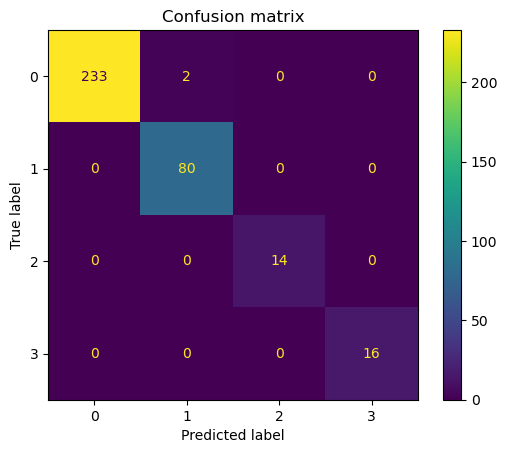

Training acc score: 1.0
Training null acc: 0.7047756874095513

Testing acc score: 0.9942028985507246
Testing null acc: 0.6811594202898551

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       233
           1       1.00      0.98      0.99        82
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        16

    accuracy                           0.99       345
   macro avg       1.00      0.99      1.00       345
weighted avg       0.99      0.99      0.99       345



In [42]:
# Model evaluation

def evaluate_model(model, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    cm = multilabel_confusion_matrix(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in y.unique()])
    disp.plot()
    plt.title("Confusion matrix")
    plt.show()
    print("Training acc score:", accuracy_score(y_train, y_train_pred))
    print("Training null acc:", y_train.value_counts().max() / len(y_train))
    print()
    print("Testing acc score:", accuracy_score(y_test, y_pred))
    print("Testing null acc:", y_test.value_counts().max() / len(y_test))
    print()
    print(classification_report(y_pred,y_test))

evaluate_model(model, X_test, y_test)

# 5. Tuning

In [43]:
base_model = XGBClassifier(random_state=42)

params = {
    'n_estimators': [10, 25, 50, 75, 100, 125, 150, 175, 200],
    "grow_policy": ["depthwise", "lossguide"],
    "learning_rate": [0.01, 0.05, 0.1, 0.3, 0.6],
}

grid_search = GridSearchCV(estimator=base_model, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [44]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 90 candidates, totalling 360 fits
CPU times: total: 1.11 s
Wall time: 9 s


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'grow_policy': ['depthwise', 'lossguide'], 'learning_rate': [0.01, 0.05, ...], 'n_estimators': [10, 25, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,4
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'multi:softprob'


In [45]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_grow_policy,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
87,0.148080,0.101782,0.012347,0.013228,lossguide,0.6,150,"{'grow_policy': 'lossguide', 'learning_rate': ...",0.985549,0.979769,0.982609,0.991304,0.984808,0.004271,1
86,0.076465,0.001085,0.005631,0.000413,lossguide,0.6,125,"{'grow_policy': 'lossguide', 'learning_rate': ...",0.985549,0.979769,0.982609,0.991304,0.984808,0.004271,1
88,0.105561,0.001389,0.006178,0.000197,lossguide,0.6,175,"{'grow_policy': 'lossguide', 'learning_rate': ...",0.985549,0.979769,0.982609,0.991304,0.984808,0.004271,1
43,0.179743,0.031943,0.009314,0.004234,depthwise,0.6,175,"{'grow_policy': 'depthwise', 'learning_rate': ...",0.985549,0.979769,0.982609,0.991304,0.984808,0.004271,1
42,0.157919,0.020970,0.006461,0.000711,depthwise,0.6,150,"{'grow_policy': 'depthwise', 'learning_rate': ...",0.985549,0.979769,0.982609,0.991304,0.984808,0.004271,1


In [47]:
best_params = grid_search.best_estimator_
best_params

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


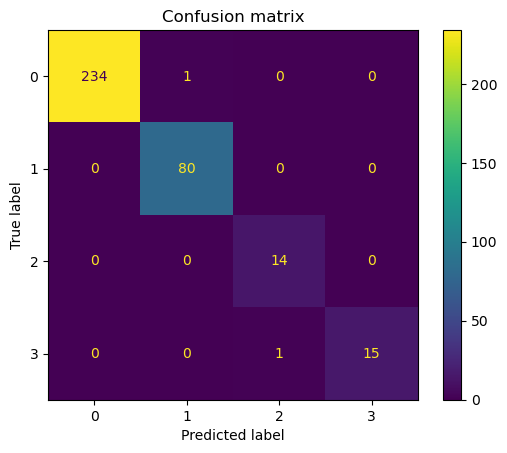

Training acc score: 1.0
Training null acc: 0.7047756874095513

Testing acc score: 0.9942028985507246
Testing null acc: 0.6811594202898551

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       234
           1       1.00      0.99      0.99        81
           2       1.00      0.93      0.97        15
           3       0.94      1.00      0.97        15

    accuracy                           0.99       345
   macro avg       0.98      0.98      0.98       345
weighted avg       0.99      0.99      0.99       345



In [48]:
# Evaluate the best model
evaluate_model(best_params, X_test, y_test)

# 6. Testing Model (if test dataset exists)